
# 🎓 Projet 8 : Analyse de Sentiment en Santé Mentale
## Version Débutant - "Je te montre, puis tu répètes"

---

### 🎯 L'Objectif de ce Projet

Les réseaux sociaux peuvent révéler des signes de dépression ou d'anxiété. Votre mission est de **détecter l'état mental** à partir de posts textuels (`Normal`, `Depressed`, `Anxious`) afin de pouvoir intervenir et proposer du soutien.

**Ce que vous allez apprendre :**
- 📝 Analyser des **données textuelles** (NLP - Natural Language Processing)
- 🕐 Extraire des features temporelles (heure, weekend, etc.)
- 🔤 Créer des features NLP (longueur, sentiment, mots négatifs)
- 🤖 Utiliser `RandomForestClassifier` pour la **classification multi-classe**
- 📊 Comparer les performances sur 3 catégories avec **F1-Score**

---

> **💡 Comment utiliser ce notebook :**
> 1. **Les cellules avec du code complet** → Lisez et exécutez-les pour voir l'exemple
> 2. **Les cellules avec # TODO** → C'est votre tour ! Répétez la technique
> 3. **Les Questions ❓** → Réfléchissez avant de passer à la suite

---



# 📋 SESSION 1 : From Raw Data to Clean Insights (45 min)

## Part 1: The Setup (10 min)

### 📘 Theory: Les Bibliothèques

Nous allons utiliser des outils spécialement conçus pour le **texte** (NLTK, TextBlob).


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuration
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# NLP Libraries (on va les installer si elles manquent)
try:
    from textblob import TextBlob
    print("✅ TextBlob disponible")
except:
    print("⚠️ TextBlob manquant. Installez avec: pip install textblob")

print("✅ Bibliothèques importées !")


⚠️ TextBlob manquant. Installez avec: pip install textblob
✅ Bibliothèques importées !



### 🛠️ Étape 1.1 : Charger les Données
Le fichier est `sante_mentale.csv`.


In [2]:

df = pd.read_csv('sante_mentale.csv')

print("📊 Aperçu des données :")
display(df.head())
print(f"\n✅ Dimensions : {df.shape[0]} posts, {df.shape[1]} colonnes")
print(f"\nℹ️ Colonnes : {df.columns.tolist()}")


📊 Aperçu des données :


,ID_Post,Texte,Horodatage,Plateforme,Etiquette
0,1,I feel work and friend. Just happy today.,2023-01-14 12:33:00,Reddit,Normal
1,2,I feel lunch and movie. Just game today.,2023-01-02 07:55:00,Twitter,Normal
2,3,I feel dread and future. Just dread today.,2023-01-05 03:58:00,Twitter,Anxious
3,4,I feel work and lunch. Just lunch today.,2023-01-21 16:17:00,Reddit,Normal
4,5,I feel weather and lunch. Just cool today.,2023-01-13 21:34:00,Reddit,Normal



✅ Dimensions : 800 posts, 5 colonnes

ℹ️ Colonnes : ['ID_Post', 'Texte', 'Horodatage', 'Plateforme', 'Etiquette']



> **💡 Tip:** Notez la colonne `Texte` - c'est là que se trouve l'information principale ! 
> `Horodatage` nous permettra d'extraire l'heure, et `Plateforme` est catégorique.



## Part 2: The Sanity Check (15 min)

### 📘 Theory: Valeurs Manquantes
Vérifions si nous avons des trous dans nos données.


In [3]:

print("🔍 Valeurs manquantes :")
print(df.isnull().sum())


🔍 Valeurs manquantes :
ID_Post       0
Texte         5
Horodatage    0
Plateforme    0
Etiquette     0
dtype: int64



### 🛠️ Exemple : Remplir 'Texte'
Pour le texte manquant, nous allons utiliser un texte neutre par défaut.


In [4]:

df['Texte'].fillna("No text", inplace=True)
print("✅ Texte manquant rempli avec : 'No text'")


✅ Texte manquant rempli avec : 'No text'


C:\Users\Mehdi\AppData\Local\Temp\ipykernel_10160\3432400200.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Texte'].fillna("No text", inplace=True)



### 🛠️ Vérification des Duplicates


In [5]:

print(f"🔍 Duplicates trouvés : {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print("✅ Duplicates supprimés !")


🔍 Duplicates trouvés : 0



## Part 3: Exploratory Data Analysis (20 min)

### 📊 Visualisation 1 : Distribution des Étiquettes
Combien de posts sont `Normal`, `Depressed`, `Anxious` ?


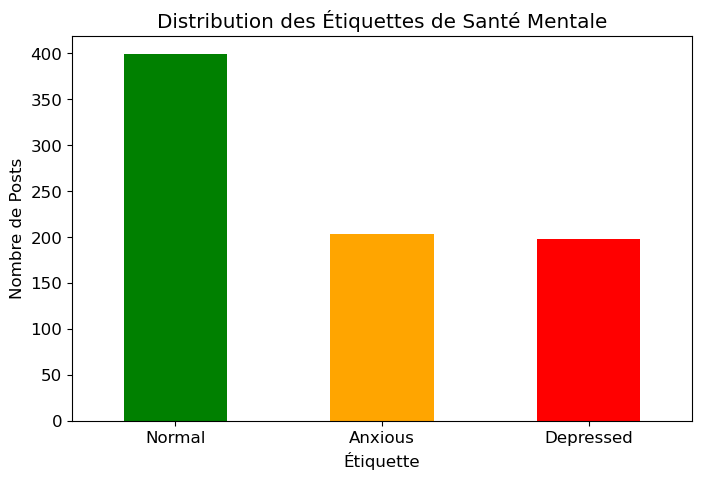


Pourcentages :
Etiquette
Normal       49.875
Anxious      25.375
Depressed    24.750
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(8, 5))
etiquette_counts = df['Etiquette'].value_counts()
colors = ['green', 'orange', 'red']
etiquette_counts.plot(kind='bar', color=colors)
plt.title('Distribution des Étiquettes de Santé Mentale')
plt.xlabel('Étiquette')
plt.ylabel('Nombre de Posts')
plt.xticks(rotation=0)
plt.show()

print("\nPourcentages :")
print(df['Etiquette'].value_counts(normalize=True) * 100)



> **⚠️ Warning:** La classe `Normal` est légèrement majoritaire (~50%), mais les classes `Depressed` et `Anxious` sont importantes à détecter !



### 🛠️ À vous de jouer !
Visualisez la répartition des posts par **Plateforme** avec un graphique en barres.


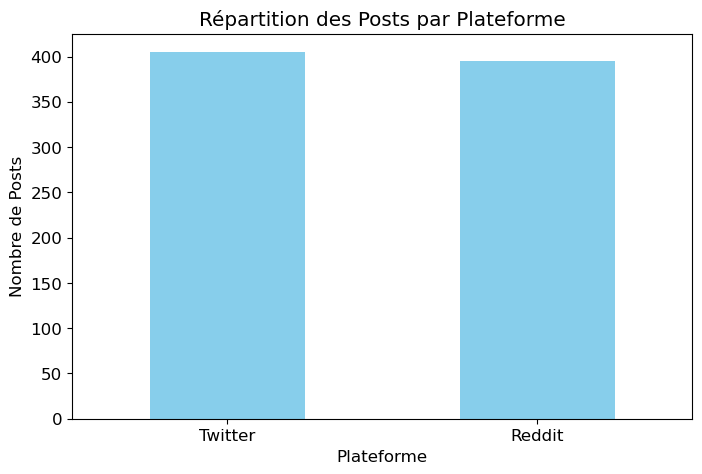

In [12]:

# TODO: Graphique en barres pour Plateforme

plt.figure(figsize=(8, 5))
df['Plateforme'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Répartition des Posts par Plateforme')
plt.xlabel('Plateforme')
plt.ylabel('Nombre de Posts')
plt.xticks(rotation=0)
plt.show()



### ❓ Question de Réflexion
Quelle plateforme a le plus de posts ? Cela pourrait-il influencer notre modèle ?



### 📊 Visualisation 2 : Longueur du Texte par Étiquette
Les posts déprimés ou anxieux sont-ils plus courts/longs ?


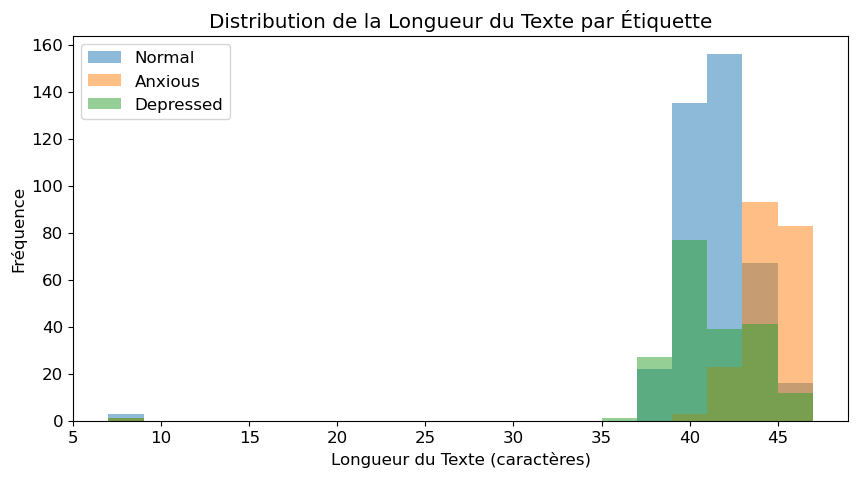

In [8]:

# Créer une feature temporaire pour la longueur
df['Text_Length_Temp'] = df['Texte'].str.len()

plt.figure(figsize=(10, 5))
for etiquette in df['Etiquette'].unique():
    subset = df[df['Etiquette'] == etiquette]['Text_Length_Temp']
    plt.hist(subset, alpha=0.5, label=etiquette, bins=20)

plt.title('Distribution de la Longueur du Texte par Étiquette')
plt.xlabel('Longueur du Texte (caractères)')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

df = df.drop(columns=['Text_Length_Temp'])  # Nettoyage



# 📋 SESSION 2 : The Art of Feature Engineering (45 min)

## Part 1: The Concept (10 min)

### 🧠 Qu'est-ce que le Feature Engineering ?

**Analogie :** Imaginez que vous êtes un détective psychologue. Un texte brut, c'est comme une conversation enregistrée. Vous devez extraire des **indices** :
- 📏 Combien de mots utilisent-ils ? (Longueur)
- 😡 Y a-t-il des mots négatifs ? (Sentiment)
- 🕐 À quelle heure ont-ils posté ? (Contexte temporel)

C'est exactement ce que nous allons faire avec le **NLP (Natural Language Processing)**.

---

## Part 2: The Lab - Choose Your Recipe (30 min)

### 📝 Recipe 3: Text & NLP (PRIMARY)

#### 📘 Theory: Features Textuelles de Base

Commençons simple :
- **Text_Length** : Nombre de caractères
- **Word_Count** : Nombre de mots
- **Avg_Word_Length** : Longueur moyenne des mots


In [9]:

# Exemple complet pour Text_Length
df['Text_Length'] = df['Texte'].str.len()
print("✅ Feature Text_Length créée !")
print(df[['Texte', 'Text_Length']].head(3))


✅ Feature Text_Length créée !
                                        Texte  Text_Length
0   I feel work and friend. Just happy today.           41
1    I feel lunch and movie. Just game today.           40
2  I feel dread and future. Just dread today.           42



### 🛠️ À vous de jouer !
Créez la feature **Word_Count** (nombre de mots dans `Texte`).

**Astuce :** Utilisez `.str.split().str.len()`


In [10]:

# TODO: Créer Word_Count

# df['Word_Count'] = df['Texte'].str.split().str.len()
# print("✅ Feature Word_Count créée !")



#### 📘 Theory: Analyse de Sentiment avec TextBlob

**TextBlob** peut analyser le **sentiment** (positif/négatif) et la **subjectivité** (opinion vs fait).

- **Polarity** : -1 (très négatif) → +1 (très positif)
- **Subjectivity** : 0 (objectif) → 1 (subjectif)


In [13]:
from textblob import TextBlob

# Exemple pour Sentiment_Polarity
def get_polarity(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

df['Sentiment_Polarity'] = df['Texte'].apply(get_polarity)
print("✅ Feature Sentiment_Polarity créée !")
print(df[['Texte', 'Sentiment_Polarity']].head(3))


ModuleNotFoundError: No module named 'textblob'


### 🛠️ À vous de jouer !
Créez **Sentiment_Subjectivity** en adaptant la fonction ci-dessus.

**Astuce :** Remplacez `.sentiment.polarity` par `.sentiment.subjectivity`


In [ ]:

def get_subjectivity(text):
     try:
         return TextBlob(str(text)).sentiment.subjectivity
     except:
         return 0

df['Sentiment_Subjectivity'] = df['Texte'].apply(get_subjectivity)
print("✅ Feature Sentiment_Subjectivity créée !")



#### 🎯 Recipe 6: Domain-Specific Features (Mental Health)

**Contexte Métier :** Pour la santé mentale, certains mots sont des **indicateurs forts** :
- Mots négatifs : "sad", "alone", "hopeless", "tired"
- Mots urgents : "suicide", "hurt myself", "end it"


In [ ]:

# Liste de mots négatifs
negative_words = ['sad', 'alone', 'hopeless', 'tired', 'depressed', 'anxious', 'worry', 'fear', 'bad', 'awful']

# Compter les mots négatifs
def count_negative_words(text):
    text_lower = str(text).lower()
    return sum([1 for word in negative_words if word in text_lower])

df['Negative_Word_Count'] = df['Texte'].apply(count_negative_words)
df['Has_Negative_Words'] = (df['Negative_Word_Count'] > 0).astype(int)

print("✅ Features Negative_Word_Count et Has_Negative_Words créées !")



### 🛠️ À vous de jouer !
Créez une feature **Has_Urgent_Keywords** pour détecter les mots liés aux idées suicidaires.

**Liste suggérée :** `['suicide', 'kill', 'die', 'death', 'end it', 'hurt myself']`


In [ ]:

# TODO: Créer Has_Urgent_Keywords

# urgent_words = ['suicide', 'kill', 'die', 'death', 'end it', 'hurt myself']
# def has_urgent(text):
#     text_lower = str(text).lower()
#     return int(any(word in text_lower for word in urgent_words))

# df['Has_Urgent_Keywords'] = df['Texte'].apply(has_urgent)
# print("✅ Feature Has_Urgent_Keywords créée !")



### 🕐 Recipe 1: Dates & Time

#### 📘 Theory: Extraction de Features Temporelles

L'heure du post peut indiquer l'état mental (posts nocturnes, weekends, etc.).


In [ ]:

# Convertir Horodatage en datetime
df['Horodatage'] = pd.to_datetime(df['Horodatage'])

# Extraire Hour
df['Hour'] = df['Horodatage'].dt.hour
print("✅ Feature Hour créée !")
print(df[['Horodatage', 'Hour']].head(3))



### 🛠️ À vous de jouer !
Créez les features suivantes :
1. **Is_Weekend** : 1 si samedi/dimanche, 0 sinon (DayOfWeek >= 5)
2. **Is_Night** : 1 si entre 22h et 6h, 0 sinon


In [ ]:

# TODO: Créer Is_Weekend et Is_Night

# df['DayOfWeek'] = df['Horodatage'].dt.dayofweek
# df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)

# df['Is_Night'] = ((df['Hour'] >= 22) | (df['Hour'] <= 6)).astype(int)
# print("✅ Features Is_Weekend et Is_Night créées !")



### 🏷️ Recipe 2: Categories

Encodons la **Plateforme** avec One-Hot Encoding.


In [ ]:

df = pd.get_dummies(df, columns=['Plateforme'], prefix='Platform')
print("✅ Encodage de Plateforme terminé !")



## Part 3: Final Prep (5 min)

### 🧹 Nettoyage Final
Supprimons les colonnes inutiles.


In [ ]:

# Supprimer les colonnes non nécessaires
columns_to_drop = ['ID_Post', 'Texte', 'Horodatage']
# Optionnel : garder DayOfWeek ou le supprimer si déjà transformé
if 'DayOfWeek' in df.columns:
    columns_to_drop.append('DayOfWeek')

df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

print(f"✅ Colonnes restantes : {df.columns.tolist()}")



### 🎯 Préparer X et y


In [ ]:

X = df.drop(columns=['Etiquette'])
y = df['Etiquette']

print(f"✅ Prêt ! X shape: {X.shape}, y shape: {y.shape}")
print(f"Features : {X.columns.tolist()}")



# 📋 SESSION 3 : Building & Trusting Your Model (45 min)

## Part 1: The Split (10 min)

Pour la classification multi-classe, nous utilisons `stratify=y` pour garder les proportions.


In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Split stratifié effectué !")
print(f"Train : {X_train.shape}, Test : {X_test.shape}")



## Part 2: Training (15 min)

### 🤖 RandomForestClassifier pour Multi-Classe
Pas besoin de modification spéciale. RandomForest gère automatiquement les 3 classes.


In [ ]:

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)

print("🚀 Entraînement...")
model.fit(X_train, y_train)
print("✅ Modèle entraîné !")



## Part 3: Evaluation (20 min)

### 📊 Métriques pour Multi-Classe

- **Accuracy** : Pourcentage global de prédictions correctes
- **F1-Score** : Moyenne harmonique de Précision et Recall (par classe)
- **Confusion Matrix** : Voir où le modèle se trompe


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 ACCURACY : {accuracy:.2%}")
print("\n📊 Rapport complet (par classe) :")
print(classification_report(y_test, y_pred))



> **💡 Tip:** Regardez le **F1-Score** pour `Depressed` et `Anxious`. Ce sont les classes les plus importantes à détecter !



### 🛠️ À vous de jouer !
Affichez la **Matrice de Confusion** pour voir les erreurs de classification.


In [ ]:

# TODO: Matrice de Confusion

# import matplotlib.pyplot as plt
# cm = confusion_matrix(y_test, y_pred, labels=['Normal', 'Depressed', 'Anxious'])
# plt.figure(figsize=(8, 6))
# plt.imshow(cm, cmap='Blues', interpolation='nearest')
# plt.colorbar()
# plt.title('Matrice de Confusion')
# plt.xlabel('Prédit')
# plt.ylabel('Réel')
# tick_marks = range(3)
# plt.xticks(tick_marks, ['Normal', 'Depressed', 'Anxious'])
# plt.yticks(tick_marks, ['Normal', 'Depressed', 'Anxious'])
# for i in range(3):
#     for j in range(3):
#         plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
# plt.show()



## 🎁 Part 4: Going Further (Bonus - 15-30 mins)

The main model is trained! Now let's tackle the optional challenges from the project brief.

### Bonus Task 1: Analyser les Tendances d'Humeur par Moment de la Journée

**Goal:** Voir si certaines heures sont associées à plus de dépression ou d'anxiété.

**Why it matters:** Cela peut aider à déployer des interventions ciblées (ex: chatbot de soutien actif la nuit).

**Approach:**
1. Grouper les posts par `Hour` et `Etiquette`
2. Compter les occurrences
3. Visualiser avec un graphique en lignes ou heatmap


In [ ]:

# TODO: Tendances par heure
# Recréez la colonne Hour si nécessaire à partir des données originales
# ou sauvegardez-la avant Session 2

# df_original = pd.read_csv('sante_mentale.csv')
# df_original['Horodatage'] = pd.to_datetime(df_original['Horodatage'])
# df_original['Hour'] = df_original['Horodatage'].dt.hour

# mood_by_hour = df_original.groupby(['Hour', 'Etiquette']).size().unstack(fill_value=0)
# mood_by_hour.plot(kind='line', figsize=(12, 6), marker='o')
# plt.title('Tendances d\'Humeur par Heure de la Journée')
# plt.xlabel('Heure')
# plt.ylabel('Nombre de Posts')
# plt.legend(title='Étiquette')
# plt.grid(True)
# plt.show()



### Bonus Task 2: Identifier les Mots Déclencheurs pour Chaque Catégorie

**Goal:** Quels mots apparaissent le plus souvent dans les posts `Depressed` vs `Anxious` vs `Normal` ?

**Why it matters:** Comprendre le vocabulaire associé à chaque état mental pour affiner les interventions.

**Approach:**
1. Séparer le texte par étiquette
2. Compter les mots les plus fréquents (après nettoyage : minuscules, stopwords)
3. Afficher les Top 10 mots par catégorie


In [ ]:

# TODO: Mots déclencheurs
# from collections import Counter
# import re

# df_original = pd.read_csv('sante_mentale.csv')

# def get_top_words(df, label, top_n=10):
#     texts = df[df['Etiquette'] == label]['Texte'].dropna()
#     all_words = []
#     for text in texts:
#         words = re.findall(r'\b[a-z]+\b', text.lower())  # Mots en minuscules
#         all_words.extend(words)
#     
#     # Retirer les stopwords basiques (optionnel, pour simplifier)
#     stopwords = ['i', 'and', 'the', 'a', 'to', 'is', 'it', 'of', 'in', 'for', 'on', 'with']
#     filtered_words = [w for w in all_words if w not in stopwords and len(w) > 2]
#     
#     return Counter(filtered_words).most_common(top_n)

# for label in ['Normal', 'Depressed', 'Anxious']:
#     print(f"\n🔑 Top 10 mots pour {label}:")
#     print(get_top_words(df_original, label))



### Bonus Task 3: Regrouper les Utilisateurs en Groupes de Soutien

**Goal:** Utiliser le clustering pour identifier des profils similaires (ex: "Anxieux nocturnes", "Déprimés le week-end").

**Why it matters:** Créer des groupes de soutien homogènes pour une meilleure entraide.

**Approach:**
1. Utiliser KMeans sur les features `Sentiment_Polarity`, `Negative_Word_Count`, `Is_Night`
2. Créer 3-4 clusters
3. Analyser la composition de chaque cluster


In [ ]:

# TODO: Clustering KMeans
# from sklearn.cluster import KMeans

# # Créer un dataframe avec les features importantes
# features_for_clustering = df[['Sentiment_Polarity', 'Negative_Word_Count', 'Is_Night']].copy()
# # (Assurez-vous que ces features existent dans df)

# kmeans = KMeans(n_clusters=3, random_state=42)
# df['Support_Group'] = kmeans.fit_predict(features_for_clustering)

# print("✅ Clustering effectué !")
# print("\nDistribution des groupes :")
# print(df['Support_Group'].value_counts())

# # Analyser chaque groupe
# for group in range(3):
#     print(f"\n--- Groupe {group} ---")
#     subset = df[df['Support_Group'] == group]
#     print(f"Taille : {len(subset)}")
#     print(f"Sentiment moyen : {subset['Sentiment_Polarity'].mean():.2f}")
#     print(f"% de posts nocturnes : {subset['Is_Night'].mean() * 100:.1f}%")



### Bonus Task 4: Détecter les Cas Urgents

**Goal:** Créer un système d'alerte pour les posts contenant des mots-clés d'idées suicidaires.

**Why it matters:** Priorité absolue - sauver des vies en détectant les signaux de danger immédiat.

**Approach:**
1. Utiliser la feature `Has_Urgent_Keywords` créée précédemment
2. Filtrer les posts urgents
3. Afficher un tableau récapitulatif avec recommandations


In [ ]:

# TODO: Système d'alerte urgente
# df_original = pd.read_csv('sante_mentale.csv')

# urgent_words = ['suicide', 'kill', 'die', 'death', 'end it', 'hurt myself']
# def has_urgent(text):
#     text_lower = str(text).lower()
#     return int(any(word in text_lower for word in urgent_words))

# df_original['Has_Urgent_Keywords'] = df_original['Texte'].apply(has_urgent)

# urgent_cases = df_original[df_original['Has_Urgent_Keywords'] == 1]

# print(f"🚨 ALERTE : {len(urgent_cases)} cas urgents détectés !")
# print("\nDétails des cas urgents :")
# display(urgent_cases[['ID_Post', 'Texte', 'Etiquette', 'Horodatage']])

# print("\n📞 RECOMMANDATION : Ces posts nécessitent une intervention immédiate (contact ligne de prévention du suicide).")



---

## 🎉 Félicitations !

Vous avez terminé le Projet 8 ! Vous savez maintenant :
- ✅ Extraire des features NLP (longueur, sentiment, mots-clés)
- ✅ Analyser des données temporelles
- ✅ Classifier des états mentaux avec Machine Learning
- ✅ Détecter des cas urgents pour sauver des vies

**Next Steps :**
- Testez d'autres modèles (Logistic Regression, SVM)
- Ajoutez plus de mots-clés contextuels
- Créez une interface web pour le système d'alerte
